Dataset loaded successfully:
   CustomerID  Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
0       50001      1     4.0         Mobile Phone         3              6.0   
1       50002      1     NaN                Phone         1              8.0   
2       50003      1     NaN                Phone         1             30.0   
3       50004      1     0.0                Phone         3             15.0   
4       50005      1     0.0                Phone         1             12.0   

  PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  \
0           Debit Card  Female             3.0                         3   
1                  UPI    Male             3.0                         4   
2           Debit Card    Male             2.0                         4   
3           Debit Card    Male             2.0                         4   
4                   CC    Male             NaN                         3   

     PreferedOrderCat  Satisfacti

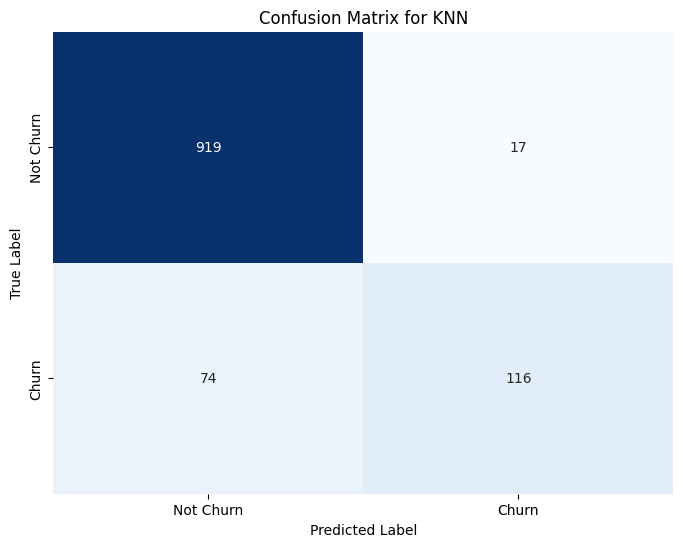


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       936
           1       0.87      0.61      0.72       190

    accuracy                           0.92      1126
   macro avg       0.90      0.80      0.84      1126
weighted avg       0.92      0.92      0.91      1126


Note on Feature Importance for K-Nearest Neighbors (KNN):

KNN is a non-parametric, instance-based learning algorithm. It does not learn explicit weights
or coefficients for features like linear models (e.g., Logistic Regression) or tree-based models.
Therefore, extracting feature importance directly from a trained KNN model is not straightforward.

Alternative methods to assess feature importance in the context of KNN include:
1. Permutation Importance: This technique involves randomly shuffling a single feature's values
   and observing the decrease in model performance. A larger drop indicates higher importance.
   This can be computatio

In [1]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Cell 2: Load the dataset
# Make sure to replace 'ECommerce_Churn_Data.csv' with the actual path/name of your dataset file if it's different.
try:
    df = pd.read_csv('ECommerce_Churn_Data.csv')
except FileNotFoundError:
    print("Error: The dataset file 'ECommerce_Churn_Data.csv' was not found.")
    print("Please download the dataset from https://www.kaggle.com/datasets/ankitverma2010/ecommerce-customer-churn-analysis-and-prediction?resource=download")
    print("and place it in the correct directory or update the file path.")
    # Exit or raise error if file not found, to prevent further cells from running with an undefined df
    df = pd.DataFrame() # Create an empty DataFrame to avoid NameError if user runs all cells

if not df.empty:
    print("Dataset loaded successfully:")
    print(df.head())
    print("\nDataset Info:")
    df.info()
    print("\nDataset Description:")
    print(df.describe())

# Cell 3: Initial Data Exploration & Preprocessing (if dataset loaded)
if not df.empty:
    # Display column names to identify the target variable and features
    print("\nColumn Names:")
    print(df.columns)

    # Assuming 'Churn' is the target variable. Verify this based on your dataset.
    # If the target column has a different name, update 'Churn' to the correct name.
    target_column = 'Churn'

    if target_column not in df.columns:
        print(f"\nError: Target column '{target_column}' not found in the dataset.")
        print("Please verify the target column name. Common names could be 'Exited', 'Target', etc.")
    else:
        print(f"\nTarget variable: '{target_column}'")
        print(df[target_column].value_counts(normalize=True))

        # Drop CustomerID if it exists, as it's an identifier and not useful for modeling
        if 'CustomerID' in df.columns:
            df = df.drop('CustomerID', axis=1)
            print("\nDropped 'CustomerID' column.")

        # Handle missing values (example: fill with mode for categorical and median for numerical)
        print("\nMissing values before handling:")
        print(df.isnull().sum())

        # Impute missing values for object type columns with mode
        for column in df.select_dtypes(include=['object']).columns:
            if df[column].isnull().any():
                df[column] = df[column].fillna(df[column].mode()[0])
                print(f"Filled missing values in '{column}' with mode.")
        
        # Impute missing values for numerical columns (excluding target) with median
        for column in df.select_dtypes(include=[np.number]).columns:
            if column != target_column and df[column].isnull().any():
                 df[column] = df[column].fillna(df[column].median())
                 print(f"Filled missing values in '{column}' with median.")


        print("\nMissing values after handling:")
        print(df.isnull().sum())
        
        # Ensure there are no more NaN values before proceeding
        if df.isnull().sum().sum() > 0:
            print("\nWarning: There are still missing values in the dataset. Review preprocessing.")
        else:
            print("\nNo missing values remaining in the dataset.")


        # Identify categorical and numerical features
        # Ensure target_column is not in features list
        features = [col for col in df.columns if col != target_column]
        categorical_features = df[features].select_dtypes(include=['object']).columns.tolist()
        numerical_features = df[features].select_dtypes(include=[np.number]).columns.tolist()

        print("\nCategorical Features:", categorical_features)
        print("Numerical Features:", numerical_features)

# Cell 4: Define Preprocessing Steps (if dataset loaded and processed)
if not df.empty and target_column in df.columns and df.isnull().sum().sum() == 0:
    # Create preprocessing pipelines for numerical and categorical features
    # KNN is sensitive to feature scaling, so StandardScaler is important.
    numerical_transformer = StandardScaler()
    # OneHotEncoder for categorical features as KNN needs numerical input.
    categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')

    # Create a preprocessor object using ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough'
    )

    # Define features (X) and target (y)
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print("\nShape of X_train:", X_train.shape)
    print("Shape of X_test:", X_test.shape)
    print("Shape of y_train:", y_train.shape)
    print("Shape of y_test:", y_test.shape)

# Cell 5: Create and Train the K-Nearest Neighbors (KNN) Model (if X_train, y_train exist)
if 'X_train' in locals() and 'y_train' in locals(): # Check if variables from previous cell exist
    # Create the KNN pipeline
    # We will use a default n_neighbors=5 for now, but this can be tuned.
    knn_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('classifier', KNeighborsClassifier())]) # Using default n_neighbors=5

    # Train the model
    print("\nTraining the KNN model...")
    knn_pipeline.fit(X_train, y_train)
    print("Model training complete.")
    
    # Optional: Hyperparameter tuning using GridSearchCV
    # This can be computationally intensive
    # param_grid = {'classifier__n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    #               'classifier__weights': ['uniform', 'distance'],
    #               'classifier__metric': ['euclidean', 'manhattan', 'minkowski']}
    #
    # print("\nStarting GridSearchCV for KNN hyperparameter tuning...")
    # grid_search_knn = GridSearchCV(knn_pipeline, param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
    # grid_search_knn.fit(X_train, y_train)
    #
    # print("\nBest parameters found by GridSearchCV:")
    # print(grid_search_knn.best_params_)
    # print(f"Best ROC AUC score from GridSearchCV: {grid_search_knn.best_score_:.4f}")
    #
    # # Use the best estimator found by GridSearchCV
    # best_knn_pipeline = grid_search_knn.best_estimator_
    # print("\nUsing the best KNN model from GridSearchCV for evaluation.")

# Cell 6: Make Predictions and Evaluate the Model (if model is trained)
# Modify this cell to use 'best_knn_pipeline' if you uncomment and run GridSearchCV in Cell 5
# For now, it uses 'knn_pipeline' (the one with default parameters)

# Check if the desired pipeline exists (either default or tuned)
model_to_evaluate = None
if 'best_knn_pipeline' in locals() and 'grid_search_knn' in locals(): # Check if GridSearchCV was run and completed
     model_to_evaluate = best_knn_pipeline
     print("\nEvaluating the best KNN model from GridSearchCV.")
elif 'knn_pipeline' in locals():
     model_to_evaluate = knn_pipeline
     print("\nEvaluating the KNN model with default parameters.")


if model_to_evaluate is not None and 'X_test' in locals(): # Check if model and test data exist
    # Make predictions
    y_pred = model_to_evaluate.predict(X_test)
    y_pred_proba = model_to_evaluate.predict_proba(X_test)[:, 1] # Probabilities for ROC AUC

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print("\nModel Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    # Plotting Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix for KNN')
    plt.show()

    print("\nClassification Report:")
    print(class_report)
else:
    if 'X_train' in locals(): # If training data was prepared but model wasn't trained
        print("\nKNN model was not trained. Skipping evaluation.")
    else: # If data loading or preprocessing failed
        print("\nData not loaded or preprocessed correctly. Skipping model training and evaluation.")


# Cell 7: Note on Feature Importance for KNN
print("""
Note on Feature Importance for K-Nearest Neighbors (KNN):

KNN is a non-parametric, instance-based learning algorithm. It does not learn explicit weights
or coefficients for features like linear models (e.g., Logistic Regression) or tree-based models.
Therefore, extracting feature importance directly from a trained KNN model is not straightforward.

Alternative methods to assess feature importance in the context of KNN include:
1. Permutation Importance: This technique involves randomly shuffling a single feature's values
   and observing the decrease in model performance. A larger drop indicates higher importance.
   This can be computationally intensive.
2. Forward/Backward Feature Selection: Iteratively adding or removing features and evaluating
   model performance.
3. Analyzing the impact of features on distances: Understanding how different features contribute
   to the distance calculations between data points, though this is less direct.

For this example, we have not implemented these more advanced feature importance techniques.
The primary focus was on building and evaluating the KNN model itself.
""")